In [1]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch import nn

In [2]:
torch.manual_seed(42)

In [3]:
# make slight modifications if GPU available;
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Computations done with {device}")

Computations done with cpu


/home/mvas/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### 1) Pick model class;

In [4]:
class ConvNet(nn.Module):
    
    # constructor
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv_net = nn.Sequential(
            # MNIST image is 1x28x28
            # first conv transforms to 5x28x28
            nn.Conv2d(in_channels=1, out_channels=5, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            # no padding so get down to 5x14x14
            nn.MaxPool2d(kernel_size=(2, 2)),
            # no padding so go to 8x12x12
            nn.Conv2d(in_channels=5, out_channels=8, kernel_size=(3, 3)),
            nn.ReLU(),
            # again no padding so go to 8x6x6
            nn.MaxPool2d(kernel_size=(2, 2)),
            # start with the flat layers
            nn.Flatten(),
            nn.Linear(6 * 6 * 8, 15 * 15),
            nn.ReLU(),
            nn.Linear(15 * 15, 10)
        )
        
    # forward pass
    def forward(self, x):
        return self.conv_net(x)

In [5]:
# instantiate ConvNet object;
model = ConvNet()

### 2) Pick loss function;

In [6]:
loss_fn = nn.CrossEntropyLoss()

### 3) Pick optimiser;

In [7]:
sgd_optim = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
def train_loop(train_dataloader, model, optim, loss_fn):
    size = len(train_dataloader.dataset)
    
    for batch, (X, y) in enumerate(train_dataloader, start=1):
        
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        # print progress
        if batch % 100 == 0:
            print(f"Train loss: {loss:.5f}\tprogress: {batch * len(X)}/{size}")

In [9]:
def test_loop(test_dataloader, model, loss_fn):
    
    test_loss, n_correct = 0, 0
    size = len(test_dataloader.dataset)
    
    # don't record operations
    with torch.no_grad():
        for (X, y) in test_dataloader:
            
            pred = model(X)
            loss = loss_fn(pred, y)
            
            # update correct predictions and test loss;
            test_loss += loss * len(X)
            n_correct += (pred.argmax(1) == y).sum().item()
            
    print(f"Test loss: {test_loss / size : .5f}\tTest Accuracy: {n_correct / size : .5f}\n")

In [10]:
# get the data
train_data = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

In [11]:
# Wrap a DataLoader on the datasets to be able to iterate;
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=50)
test_dataloader = DataLoader(test_data, batch_size=50)

In [12]:
epochs = 10

for t in range(epochs):
    print(f"Epoch {t+1}:\n----------------------------------")
    train_loop(train_dataloader, model, sgd_optim, loss_fn)
    test_loop(test_dataloader, model, loss_fn)

Epoch 1:
----------------------------------
Train loss: 2.29405	progress: 5000/60000
Train loss: 2.30661	progress: 10000/60000
Train loss: 2.29076	progress: 15000/60000
Train loss: 2.29867	progress: 20000/60000
Train loss: 2.28425	progress: 25000/60000
Train loss: 2.30317	progress: 30000/60000
Train loss: 2.29785	progress: 35000/60000
Train loss: 2.28824	progress: 40000/60000
Train loss: 2.29831	progress: 45000/60000
Train loss: 2.29207	progress: 50000/60000
Train loss: 2.27710	progress: 55000/60000
Train loss: 2.28979	progress: 60000/60000
Test loss:  2.28741	Test Accuracy:  0.15910

Epoch 2:
----------------------------------
Train loss: 2.29819	progress: 5000/60000
Train loss: 2.27122	progress: 10000/60000
Train loss: 2.28816	progress: 15000/60000
Train loss: 2.28007	progress: 20000/60000
Train loss: 2.27973	progress: 25000/60000
Train loss: 2.27879	progress: 30000/60000
Train loss: 2.27489	progress: 35000/60000
Train loss: 2.26222	progress: 40000/60000
Train loss: 2.27225	progress:

In [13]:
import matplotlib.pyplot as plt

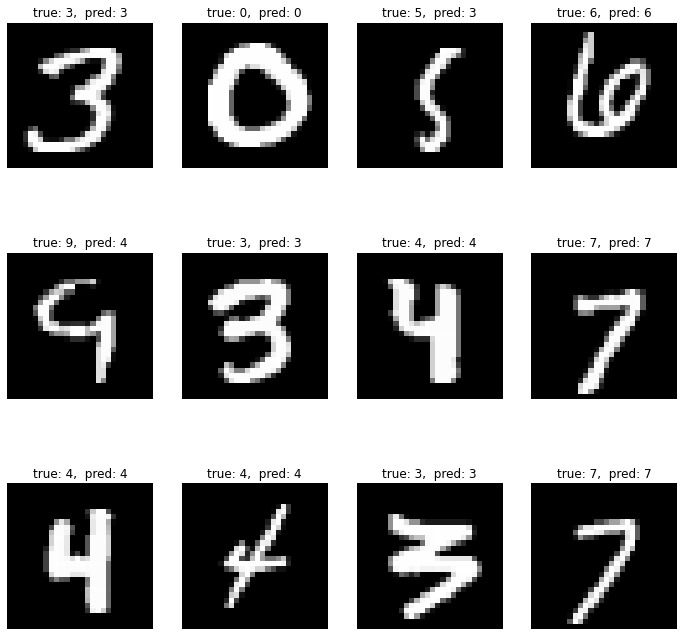

In [14]:
# plot 12 predictions;
cols, rows = 4, 3

fig = plt.figure(figsize=(12, 12))

for i in range(1, rows * cols + 1):
    
    # get a random image;
    sample_idx = torch.randint(len(train_dataloader.dataset), size=(1, )).item()
    img, label = train_data[sample_idx]
    
    # pass through the model;
    pred = model(img.reshape(1,1,28,28))
    
    fig.add_subplot(rows, cols, i)
    plt.title(f"true: {label},  pred: {pred.argmax(1).item()}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()